# Install the required packages

In [1]:
!pip install datasets wandb
!pip install -U huggingface_hub accelerate
!pip install --no-cache-dir transformers sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 3.5 MB/s eta 0:00:00


# Import the required packages

In [2]:
import tqdm
import wandb
from argparse import Namespace
from huggingface_hub import notebook_login

from datasets import load_dataset
from transformers import AutoTokenizer, PreTrainedTokenizerFast, AutoConfig,\
                        TrainingArguments, Trainer, TrainingArguments, GPT2LMHeadModel, \
                        DataCollatorForLanguageModeling, PreTrainedTokenizer

from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import WhitespaceSplit
from tokenizers.trainers import WordLevelTrainer
from tokenizers.processors import TemplateProcessing

In [3]:
notebook_login()

In [14]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Load the dataset from hugginface

In [4]:
language = 'english'
DATA = f"okbenzene2002/{language}-dataset"
dataset_card = load_dataset(DATA, split='train')
raw = dataset_card.train_test_split(test_size=0.2, shuffle=True)
sample = raw['train']['text'][0]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/3345 [00:00<?, ? examples/s]

In [5]:
sample

'PIECE_START TIME_SIGNATURE=3_4 GENRE=OTHER TRACK_START INST=71 DENSITY=1 BAR_START BAR_END BAR_START TIME_DELTA=5.566666666666666 NOTE_ON=80 TIME_DELTA=1.3333333333333333 NOTE_OFF=80 NOTE_ON=78 TIME_DELTA=1.3333333333333333 NOTE_OFF=78 NOTE_ON=82 TIME_DELTA=1.3333333333333333 NOTE_OFF=82 NOTE_ON=80 TIME_DELTA=1.3333333333333333 NOTE_OFF=80 NOTE_ON=78 TIME_DELTA=1.1 NOTE_OFF=78 BAR_END BAR_START NOTE_ON=78 TIME_DELTA=0.23333333333333334 NOTE_OFF=78 NOTE_ON=73 TIME_DELTA=1.3333333333333333 NOTE_OFF=73 NOTE_ON=70 TIME_DELTA=1.3333333333333333 NOTE_OFF=70 NOTE_ON=66 TIME_DELTA=1.3333333333333333 NOTE_OFF=66 TIME_DELTA=1.3333333333333333 NOTE_ON=63 TIME_DELTA=1.3333333333333333 NOTE_OFF=63 NOTE_ON=66 TIME_DELTA=1.3333333333333333 NOTE_OFF=66 NOTE_ON=72 TIME_DELTA=1.3333333333333333 NOTE_OFF=72 NOTE_ON=75 TIME_DELTA=1.3333333333333333 NOTE_OFF=75 NOTE_ON=78 TIME_DELTA=1.1 NOTE_OFF=78 BAR_END BAR_START NOTE_ON=78 TIME_DELTA=0.23333333333333334 NOTE_OFF=78 NOTE_ON=82 TIME_DELTA=4.0 NOTE_OFF=8

# Creating Custom Trainer

## Why not GPT-2 tokenizer?
The custom gpt-2 tokenizer will not consider the variable pattern of the midi sequence hence we can specify the special tokens separately

In [6]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer(sample).tokens()

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2406 > 1024). Running this sequence through the model will result in indexing errors


['PI',
 'EC',
 'E',
 '_',
 'ST',
 'ART',
 'ĠTIME',
 '_',
 'SIGN',
 'ATURE',
 '=',
 '3',
 '_',
 '4',
 'ĠGEN',
 'RE',
 '=',
 'OTHER',
 'ĠTR',
 'ACK',
 '_',
 'ST',
 'ART',
 'ĠINST',
 '=',
 '71',
 'ĠD',
 'ENS',
 'ITY',
 '=',
 '1',
 'ĠBAR',
 '_',
 'ST',
 'ART',
 'ĠBAR',
 '_',
 'END',
 'ĠBAR',
 '_',
 'ST',
 'ART',
 'ĠTIME',
 '_',
 'D',
 'EL',
 'TA',
 '=',
 '5',
 '.',
 '5',
 '66666666',
 '6666',
 '66',
 'ĠNOTE',
 '_',
 'ON',
 '=',
 '80',
 'ĠTIME',
 '_',
 'D',
 'EL',
 'TA',
 '=',
 '1',
 '.',
 '3333',
 '3333',
 '3333',
 '3333',
 'ĠNOTE',
 '_',
 'OFF',
 '=',
 '80',
 'ĠNOTE',
 '_',
 'ON',
 '=',
 '78',
 'ĠTIME',
 '_',
 'D',
 'EL',
 'TA',
 '=',
 '1',
 '.',
 '3333',
 '3333',
 '3333',
 '3333',
 'ĠNOTE',
 '_',
 'OFF',
 '=',
 '78',
 'ĠNOTE',
 '_',
 'ON',
 '=',
 '82',
 'ĠTIME',
 '_',
 'D',
 'EL',
 'TA',
 '=',
 '1',
 '.',
 '3333',
 '3333',
 '3333',
 '3333',
 'ĠNOTE',
 '_',
 'OFF',
 '=',
 '82',
 'ĠNOTE',
 '_',
 'ON',
 '=',
 '80',
 'ĠTIME',
 '_',
 'D',
 'EL',
 'TA',
 '=',
 '1',
 '.',
 '3333',
 '3333',
 '33

Instead we use the wordlevel tokenizer

In [7]:
wordlevel = Tokenizer(WordLevel(unk_token="[UNK]"))
wordlevel.pre_tokenizer = WhitespaceSplit()
wordlevel.pre_tokenizer.pre_tokenize_str(sample)

[('PIECE_START', (0, 11)),
 ('TIME_SIGNATURE=3_4', (12, 30)),
 ('GENRE=OTHER', (31, 42)),
 ('TRACK_START', (43, 54)),
 ('INST=71', (55, 62)),
 ('DENSITY=1', (63, 72)),
 ('BAR_START', (73, 82)),
 ('BAR_END', (83, 90)),
 ('BAR_START', (91, 100)),
 ('TIME_DELTA=5.566666666666666', (101, 129)),
 ('NOTE_ON=80', (130, 140)),
 ('TIME_DELTA=1.3333333333333333', (141, 170)),
 ('NOTE_OFF=80', (171, 182)),
 ('NOTE_ON=78', (183, 193)),
 ('TIME_DELTA=1.3333333333333333', (194, 223)),
 ('NOTE_OFF=78', (224, 235)),
 ('NOTE_ON=82', (236, 246)),
 ('TIME_DELTA=1.3333333333333333', (247, 276)),
 ('NOTE_OFF=82', (277, 288)),
 ('NOTE_ON=80', (289, 299)),
 ('TIME_DELTA=1.3333333333333333', (300, 329)),
 ('NOTE_OFF=80', (330, 341)),
 ('NOTE_ON=78', (342, 352)),
 ('TIME_DELTA=1.1', (353, 367)),
 ('NOTE_OFF=78', (368, 379)),
 ('BAR_END', (380, 387)),
 ('BAR_START', (388, 397)),
 ('NOTE_ON=78', (398, 408)),
 ('TIME_DELTA=0.23333333333333334', (409, 439)),
 ('NOTE_OFF=78', (440, 451)),
 ('NOTE_ON=73', (452, 462)

### `Special tokens for wordlevel custom trainer`
* [UNK] - Stands for "unknown". It replaces words that are not in the model's vocabulary.
* [PAD] - Used to fill in sequences to ensure they are all the same length for batch processing.
* [CLS] - Stands for "classification". It's a special token added at the beginning of the input, and its corresponding output embedding is often used for classification tasks.
* [SEP] - Acts as a separator, marking boundaries between different pieces of text.
* [MASK] - used in Masked Language Modeling (MLM) to hide tokens from the model, prompting it to predict the masked word based on context.

In [8]:
# Yield batches of 1000 texts for each iteration
def get_dataset():
  dataset = raw['train']
  for i in range(0, len(dataset), 1000):
    yield dataset[i: i+1000]['text']

In [9]:
trainer = WordLevelTrainer(special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"])
wordlevel.train_from_iterator(get_dataset(), trainer=trainer)

In [10]:
wordlevel.save('/content/drive/MyDrive/MusicGPT/new_custom_wordlevel_english.json')

# Load the tokenizer and push it to hugging-face

In [11]:
wordlevel = PreTrainedTokenizerFast.from_pretrained('/content/drive/MyDrive/MusicGPT/new_custom_wordlevel_english.json', use_fast=True)
wordlevel.add_special_tokens({
    'pad_token': '[PAD]',
    'unk_token': '[UNK]',
    'cls_token': '[CLS]',
    'sep_token': '[SEP]',
    'mask_token': '[MASK]'
})

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1930: FutureWarning: Calling PreTrainedTokenizerFast.from_pretrained() with the path to a single file or url is deprecated and won't be possible anymore in v5. Use a model identifier or the path to a directory instead.
  warnings.warn(


0

In [12]:
len(wordlevel)

2052

In [15]:
wordlevel.push_to_hub("okbenzene2002/english-tokenizer")

README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/okbenzene2002/english-tokenizer/commit/ecbfa7d68cdf9dbb66b531f191ad30dbadbd5f74', commit_message='Upload tokenizer', commit_description='', oid='ecbfa7d68cdf9dbb66b531f191ad30dbadbd5f74', pr_url=None, pr_revision=None, pr_num=None)

In [16]:
import json
address = '/content/drive/MyDrive/MusicGPT/new_custom_wordlevel_english.json'
with open(address, 'r') as f:
  data = json.load(f)

In [18]:
len(data)

9

In [19]:
tokens = data['model']['vocab'].keys()

In [20]:
# Due to the large number of tokens, let's focus on a summary of specific types of tokens
# We'll look at the distribution of "NOTE_ON", "NOTE_OFF", and "TIME_DELTA" tokens as an example
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib import rcParams
%matplotlib inline

rcParams['figure.figsize'] = 12, 8
sb.set_style('whitegrid')


# Count the occurrences of each token type
note_on_count = sum(1 for token in tokens if token.startswith("NOTE_ON"))
note_off_count = sum(1 for token in tokens if token.startswith("NOTE_OFF"))
time_delta_count = sum(1 for token in tokens if token.startswith("TIME_DELTA"))
other_tokens_count = len(tokens) - note_on_count - note_off_count - time_delta_count

# Prepare data for plotting
categories = ['NOTE_ON', 'NOTE_OFF', 'TIME_DELTA', 'Other']
counts = [note_on_count, note_off_count, time_delta_count, other_tokens_count]

print(note_on_count, note_off_count, time_delta_count, other_tokens_count)
print(categories)
print(counts)

83 83 1843 43
['NOTE_ON', 'NOTE_OFF', 'TIME_DELTA', 'Other']
[83, 83, 1843, 43]


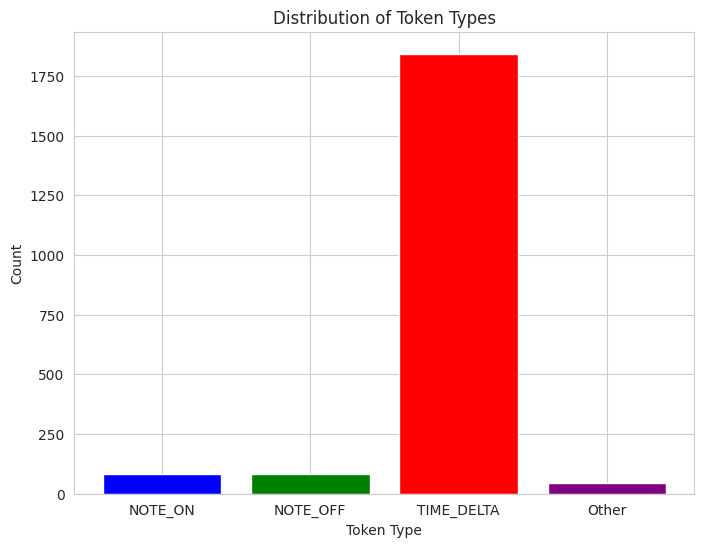

In [21]:
# Plot
plt.figure(figsize=(8, 6))
plt.bar(categories, counts, color=['blue', 'green', 'red', 'purple'])
plt.title('Distribution of Token Types')
plt.ylabel('Count')
plt.xlabel('Token Type')
plt.show()